# DuckDB Spatial

This is a short example notebook to show how to use [DuckDB Spatial](https://duckdb.org/docs/extensions/spatial.html) with Lonboard. We'll create a [HeatmapLayer](https://developmentseed.org/lonboard/latest/api/layers/heatmap-layer/) with NYC Taxi data. 

For full information on how to use DuckDB with Lonboard, [refer to the documentation](https://developmentseed.org/lonboard/latest/ecosystem/duckdb/).

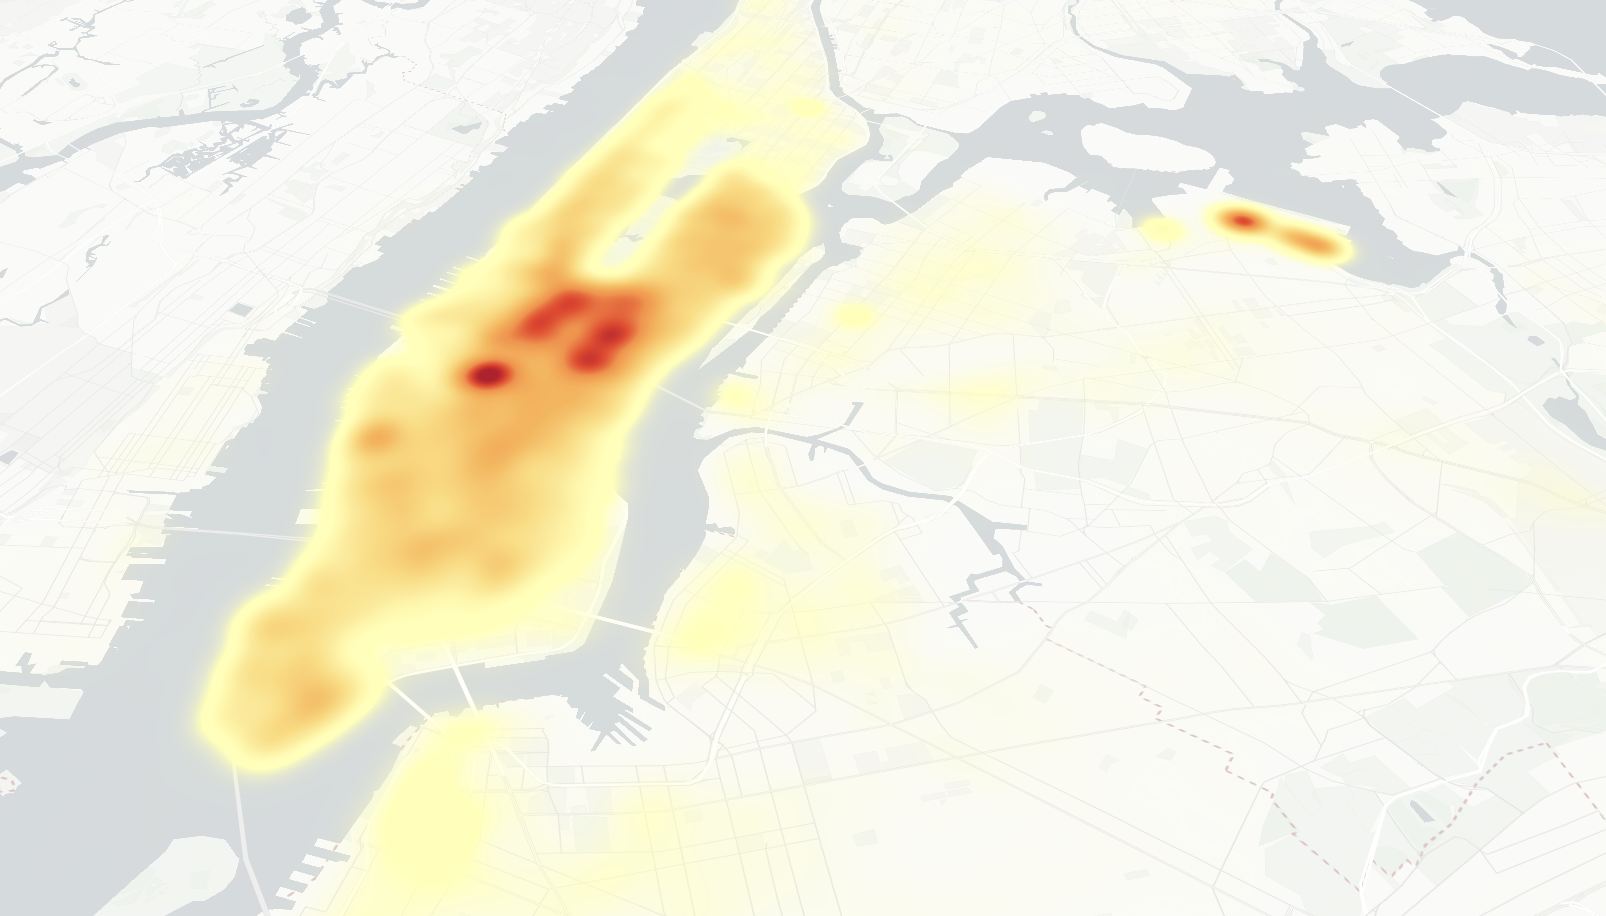

In [ ]:
import duckdb
from lonboard import HeatmapLayer, Map

Create a database connection and install and load the Spatial extension:

In [ ]:
con = duckdb.connect()
duckdb.install_extension("spatial", connection=con)
duckdb.load_extension("spatial", connection=con)

We load this data directly from the [New York City taxi dataset webpage](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page), here loading data from March 2010 (later years of data do not have exact longitude-latitude locations). We also create a geometry column with the `ST_Point` constructor, passing in the drop off longitude and latitude columns.

There are a few incorrect location values in this dataset with longitude/latitude near "null island" at (0, 0), so we pass in bounding-box filtering around the New York City region.

Then we execute this query in our connection.

In [ ]:
sql = """
CREATE TABLE rides AS
SELECT 
    *,
    ST_Point(dropoff_longitude, dropoff_latitude) as geometry
FROM "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2010-03.parquet" 
WHERE
    dropoff_longitude >= -74.6087 AND
    dropoff_latitude >= 40.2738 AND
    dropoff_longitude <= -73.4928 AND
    dropoff_latitude <= 41.1757 AND
    total_amount > 0
LIMIT 1_000_000;
"""
con.execute(sql)

Inspecting this table, we can see a variety of columns, plus our `geometry` column:

In [ ]:
con.table("rides")

To pass this data into Lonboard, we can pass a string query or "relation object" into the `from_duckdb` class method, plus a reference to our connection. Here the `con.table("rides")` call creates a relation that refers to the entire `rides` table.

In [ ]:
layer = HeatmapLayer.from_duckdb(con.table("rides"), con)

In [ ]:
m = Map(layer)
m

DuckDB Spatial does not currently export coordinate reference system information, but in this case we know the data is already in the EPSG:4326 (WGS84) coordinate system, so we can ignore the generated warning.

The heatmap by default assigns a weight of 1 to each row, so the heatmap shows the unweighted density of rides. We can change this by modifying the [`get_weight`](https://developmentseed.org/lonboard/latest/api/layers/heatmap-layer/#lonboard.HeatmapLayer.get_weight) attribute.

Let's weight the heatmap by the cost of the ride. We can do this by passing in a column from `total_amount`. We can access this column by selecting a table with only that data:

In [ ]:
total_amount_table = con.sql("SELECT total_amount from rides").arrow()

We want a single column to pass in to the layer, so we select the `total_amount` column:

In [ ]:
total_amount = total_amount_table["total_amount"]

Then we assign this onto the `get_weight` accessor

In [ ]:
layer.get_weight = total_amount

Note that the heatmap around airports such as LaGuardia is now darker. There are fewer total rides dropping off at the airport, but each one is expensive!